<h1><center>Maximizing Aggregate Recommendation Diversity: A Graph-Theoretic Approach</center></h1>
<h3><center>Course Project Demo for TAMU CSCE 670, Spring 2018</center></h3>
<center>Bowen Li, Mianzhi Yang, Kai Zheng, Yian Huang</center>

# 1. Introduction

Recommendation system is very commonly used in the real world. Many recommendation techniques have been developed and put into production for years. Popular websites are using better recommendation to give users suggestions that people might be interested in. It is beneficial for both users and business models. Individuals could always find what they want while business models selling their recommended products to more users. For example, when a customer want to buy an iPad, Amazon will recommend other Apple products based on the data from other users who also interested in this iPad. How to design a good recommendation system becomes a hot topic. But how to tell if some recommendations are "good" or not?

Major efforts in both academia and industry have been made to improve recommendation accuracy. Granted, high accuracy is fundamental to a good recommender, but it has been increasingly noted that it is not sufficient to have accuracy as the only metric in measuring recommendation quality. Some other important dimensions should be evaluated as well, such as diversity, novelty, serendipity, confidence, trust, etc. In this way, recommendations can be not only accurate but also useful to users.

Out of so many evaluation metrics, we would like to concentrate on improving the aggregate diversity of recommendations. Recommendation system focused on diversity plays a key role in increasing "long tail" effects. Users' awareness of niche products increased and therefore create a long tail in the distribution of product sales. For example, some business models (e.g. Netflix), can benefit from recommendation diversity, because more diverse recommendations would encourage users to rent more "long-tail" movies, which are less costly to license and acquire from distributors than new releases or extremely popular movies of big studios. Thus the aggregate diversity has impact on product variety and can affect sales concentration in practice.

Previous studies showed that there is an inherent tradeoff between accuracy and diversity. Therefore, maintaining accuracy while improving diversity constitutes a difficult task. Research has already found that significant diversity improvements can be obtained with increasingly smaller sacrifices to recommendation accuracy. While gaining much diversity while losing accuracy only slightly is generally acceptable, we still need to find a balance between these two factors. To evaluate accuracy, we calculated the average rating values of recommended items using for all recommendation algorithms because it is highly correlated with precision. To evaluate diversity, we use a simple absolute long-tail metric using the total number of distinct items among the top-N items recommended.

In this Demo project, we implemented a sophisticated algorithm that transform the problem of maxmizing aggregate diversity into a maximum flow problem. We paid more attention on the way to find the best set of recommendations and evaluated our implementation by examining all the recommendations that were given to all the users. We compared our graph-based method to the standard ranking method as well as the traditional re-ranking method. And we evaluate the relationships between the recommendation accuracy and the diversity. Our result showed that the graph-based approach can provide hugh diversity improvement at the cost of very little accuracy. Also, we can adjust the tolerance of accuracy loss to further tune the recommender.

# 2. Related Work

We have found several literatures that are useful for our project.

\[1\] proposed an approach that can greatly improve aggregate recommendation diversity at the cost of a little accuracy, by transforming the problem of maxmizing aggregate diversity into a maximum flow problem. Our project basically implements the algorithm introduced in this paper, so it is fundamental for the project.

\[2\] introduced some classic CF algorithms that we found useful to build a recommender. It provides a solid foundation for us to further do our job i.e. improving the aggregate recommendation diversity.

\[3\] is a very famous blog post that discussed about latent factor model. We implemented matrix factorization CF according to the steps described in it.

There are some other existing studies on improving aggregate diversity of recommendations. \[4\] introduced a new recommendation idea called LCSC that generates recommendations from those who previously recommended the target customers successfully while CF generates recommendations from those who are most similar to the target customer, and this method are shown to improve aggregate recommendation diversity. \[5\] proposed a long tail music recommender systems by removing popular artists in the rating prediction phase.

For the purpose of generating graph and solving maximum flow problem, we make use a third-party Python library called NetworkX \[6\] in the project.

References:

\[1\] Adomavicius, G., & Kwon, Y. O. (2011). Maximizing aggregate recommendation diversity: A graph-theoretic approach. CEUR Workshop Proceedings, 816, 3-10.

\[2\] John S. Breese, David Heckerman, and Carl Kadie. 1998. Empirical analysis of predictive algorithms for collaborative filtering. In Proceedings of the Fourteenth conference on Uncertainty in artificial intelligence (UAI'98), Gregory F. Cooper and Serafín Moral (Eds.). Morgan Kaufmann Publishers Inc., San Francisco, CA, USA, 43-52.

\[3\] Simon Funk. (2006). Netflix Update: Try This at Home. http://sifter.org/simon/journal/20061211.html

\[4\] Y.U. Ryu, J.K. Kim, & H.K. Kim. (2013). A Local Scoring Model for Diversified Recommendation. Proceedings of the 34th International Conference on Information Systems.

\[5\] J. Liu, M. Shang and D. Chen. (2009). Personal Recommendation Based on Weighted Bipartite Networks. Sixth International Conference on Fuzzy Systems and Knowledge Discovery, 134-137.

\[6\] NetworkX developers. (2018). Networkx. https://networkx.github.io/

# 3. Preparations

To solve the problem of maximizing aggregate recommendation diversity, we need to prepare several things.

First of all, we need to build a recommendation system. We will discuss the rating prediction algorithms and how to generate recommendations from the predicted ratings using ranking functions. We will also show our implementations to provide a sound basis for the following tasks.

Then, we want to introducce the concept of accuracy and diversity in the context of recommendation systems and how can we calculate these two metrics from recommendations.

After that, we want to discuss a simple existing re-ranking algorithm that has the ability to improve the aggregate diversity without harming too much of of accuracy. We think this can serve as a baseline for comparison with our proposed approach in the next chatper.

## 3.1. Recommendation Algorithms

The dataset we are using is from MovieLens available at [GroupLens](https://grouplens.org/). The data is stored in a `.csv` file and it has three columns that are `userId`, `movieId` and `rating`.

Since we do not care the nature of movie in this project, in the following sections we will refer them as "items" intead of "movies".

The code below is to read and pre-process the data:

In [1]:
# load the training data

from tqdm import tqdm
tqdm.monitor_interval = 0

def load_data(number_of_lines=1000):
    with open('ratings_origin.csv', 'r') as training_file:
        ratings = {}
        users = set()
        items = set()
    
        # slice to [1:] to ignore the csv header
        training_data = training_file.read().splitlines()[1:]
        
        i = 0
        
        for line in training_data:
            parts = line.split(',')
            user = int(parts[0])
            item = int(parts[1])
            rating = float(parts[2])

            users.add(user)
            items.add(item)

            if user not in ratings:
                ratings[user] = {}

            ratings[user][item] = rating
            
            i += 1
            if i == number_of_lines:
                break
        
        return ratings, users, items

number_of_ratings = 10000

# ratings: each user's rated item and its rating
# {user: {item: rating}}
ratings, users, items = load_data(number_of_ratings)

print 'number of users: %d' % len(users)
print 'number of items: %d' % len(items)

number of users: 91
number of items: 2889


After pre-processing our data, we then have two sets of users and items. Let $U$ be the set of users and $I$ be the set of items in our dataset, the rating one user $u$ have for any random item $i$ is denoted as $R(u,i)$.

Next, we need to predict all the unknown ratings based on all the known ratings. The predicted rating from one user $u$ to item $i$ is denoted as $R^*(u,i)$.

The code below is to store each user's unknown ratings:

In [2]:
# set of items that a user hasn't rated
# {user: set(item_id)}
unknown_ratings = {}

for user in users:
    unknown_ratings[user] = set()

for user in users:
    for item in items:
        if item not in ratings[user]:
            unknown_ratings[user].add(item)

### 3.1.1. Neighborhood-based CF

The first algorithm we used to predict the unknown ratings is Neighborhood-based CF. The basic idea of neighborhood-based CF method is to find the nearest neighbor of the target user and predict the unknown ratings based on the similar users.

To prepare data for the following steps, we need to first calculate each user's average rating based on all his/her know ratings:

$$Avg_u=\frac{1}{\lvert I_u\rvert}\sum_{j\in I_u}{R(u,i)}$$

In [3]:
# the average rating of all the ratings from a user
# {user: average_rating}
average_ratings = {}

for user in users:
    ratings_of_user = ratings[user].values()
    average_rating = sum(ratings_of_user) / len(ratings_of_user)
    average_ratings[user] = average_rating

We also would like to know if there are some users that rate all items the same rating.

In [4]:
# set of users whose ratings are all the same
# in the get_weight_correlation(user_a, user_i) function, if one in (user_a, user_i) is such a user, the weight will be 0
one_rating_users = set()

for user in tqdm(users):
    ratings_of_user = ratings[user].values()
    first_rating = ratings_of_user[0]
    all_same = True
    for rating in ratings_of_user:
        if first_rating != rating:
            all_same = False
            break
    if all_same:
        one_rating_users.add(user)

100%|██████████| 91/91 [00:00<?, ?it/s]


We implemented several "weight" functions based on different theories.

The first is to calcuate weight by Pearson correlation, which was defined as the basis for the weights.

The correlation between user $u$ and user $v$ is:

$$W_{Pearson\_correlation}(u,v)=\frac{\sum_i{(R(u,i)-Avg_u)(R(u,i)-Avg_v)}}{\sum_i{(R(u,i)-Avg_u)^2}\sum_i{(R(u,i)-Avg_v)}^2}$$

where the summations over $i$ are over the items for which both users $u$ and $v$ have ratings.

In [5]:
import math

cache_weight_correlation = {}

for user in users:
    cache_weight_correlation[user] = {}

def get_weight_correlation(user_a, user_i):
    if user_a in one_rating_users or user_i in one_rating_users:
        return 0.0
    
    if user_a in cache_weight_correlation[user_i]:
        return cache_weight_correlation[user_i][user_a]
    if user_i in cache_weight_correlation[user_a]:
        return cache_weight_correlation[user_a][user_i]
    
    numerator_sum = 0.0
    denominator_sum_a = 0.0
    denominator_sum_i = 0.0

    for item_j in ratings[user_a]:
        if item_j in ratings[user_i]:
            rating_aj = ratings[user_a][item_j]
            rating_ij = ratings[user_i][item_j]
            delta_a = rating_aj - average_ratings[user_a]
            delta_i = rating_ij - average_ratings[user_i]
            numerator_sum += delta_a * delta_i
            denominator_sum_a += delta_a ** 2
            denominator_sum_i += delta_i ** 2
    
    # the denominator_sum can still be 0, if:
    #    1. the two users have no common rating
    # or 2. the two users have some common ratings, but for at least one of them, all the common ratings are equal to his/her average rating
    #       for example, a user has [3.0, 4.0, 4.0, 5.0], but only has the two "4.0"s with the other user in common
    # also, by math, if denominator_sum is 0.0, numerator_sum must be 0.0 in the first place
    if denominator_sum_a == 0.0 or denominator_sum_i == 0.0:
        weight = 0.0
    else:
        weight = numerator_sum / math.sqrt(denominator_sum_a * denominator_sum_i)
    
    cache_weight_correlation[user_a][user_i] = weight
    return weight

The second is to calcuate weight by vector similarity:

$$W_{vector\_similarity}(u,v)=\sum_i\frac{R(u,i)}{\sqrt{\sum_{j\in{I_u}}{R(u,i)^2}}}\frac{R(u,i)}{\sqrt{\sum_{j\in{I_v}}{R(u,i)^2}}}$$

In [6]:
# root of sum of square of all the ratings: v1^2 + v2^2 + ...+vN^2
# {user: square_sum_rating}
root_sum_square_ratings = {}

for user in users:
    sum_square_ratings = 0.0
    for item in ratings[user]:
        sum_square_ratings += ratings[user][item] ** 2.0
    root = math.sqrt(sum_square_ratings)
    root_sum_square_ratings[user] = root
#     print 'root of sum of squared ratings of user %d: %f' % (user, root)

def get_weight_vector_similarity(user_a, user_i):
    res = 0.0
    for item in ratings[user_a]:
        if item in ratings[user_i]:
            a = ratings[user_a][item] / root_sum_square_ratings[user_a]
            i = ratings[user_i][item] / root_sum_square_ratings[user_i]
            res += a * i
    return res

Then, the predicted rating of a user $u$ for item $i$, $R*(u,i)$, is a weighted sum of the ratings of the other users:

$$R^*(u,i)=Avg_u+k\sum_{v=1}^nW(u,v)(R(v,i)-Avg_v)$$

In [7]:
def fit_rating_range(rating):
    if rating < 1.0:
        return 1.0
    elif rating > 5.0:
        return 5.0
    return rating

def predict_user_based_CF(user_a, item_j, get_weight=get_weight_correlation):
    weighted_difference_sum = 0.0
    weight_sum = 0.0
    
    for user_i in users:
        if item_j in ratings[user_i]:
            weight = get_weight(user_a, user_i)
            weight_sum += math.fabs(weight)
            weighted_difference_sum += weight * (ratings[user_i][item_j] - average_ratings[user_i])
    
    predict = average_ratings[user_a]
    
    if weight_sum != 0.0:
        k = 1.0 / weight_sum
        predict += k * weighted_difference_sum

#     predict = fit_rating_range(predict)
    
    return predict

def predict_user_based_CF_all(get_weight=get_weight_correlation):
    predicted_ratings = {}
    
    for user in tqdm(users):
        predicted_ratings[user] = {}
        for item in unknown_ratings[user]:
            predicted_ratings[user][item] = predict_user_based_CF(user, item, get_weight)

    return predicted_ratings

In [8]:
predicted_ratings_user_based_CF = predict_user_based_CF_all()

100%|██████████| 91/91 [00:03<00:00, 24.50it/s]


### 3.1.2 Matrix Factorization CF

After we implemented the neighborhood-based CF as described above, we found it needs too much time to generate recommendations. For the sake of better performance, we also implemented CF using matrix factorization.

The basic idea of Matrix factorization CF is to use the existing ratings to learn a model with $k$ latent variables for users and items. In this project, we apply Matrix factorization CF method to predict the unknown ratings by mapping the user-item matrix into latent factors models, and then the predicted rating of item $i$ for user $u$ can be computed as an inner product of the user-factors vector and item-factors vector. This method has been shown to produce increasingly accurate result than heuristic-based methods.

We implemented our latent factor model mainly based on the very famous blog article [Try This at Home](http://sifter.org/simon/journal/20061211.html) by Simon Funk.

Below is the generation of our latent model:

In [9]:
import numpy as np
import sys

index_to_user = {}
user_to_index = {}
for index, user in enumerate(list(users)):
    index_to_user[index] = user
    user_to_index[user] = index

index_to_item = {}
item_to_index = {}
for index, item in enumerate(list(items)):
    index_to_item[index] = item
    item_to_index[item] = index

def predict(U, user_index, M, item_index):
    rating = np.dot(U[user_index], M[item_index].T)
    return rating

# Simon Funk's approach
# To prevent overfitting:
# 1. no-improvement-in-n strategy
# 2. improvement_threshold
def generate_LFM(number_of_features, no_improvement_in_n=10, improvement_threshold=0.000001, learning_rate=0.01, K=0.02):
    U = np.random.rand(len(users), number_of_features) / math.sqrt(number_of_features)
    M = np.random.rand(len(items), number_of_features) / math.sqrt(number_of_features)
    
    # according to Simon Funker's blog
    max_epoches = number_of_features * 120
    
    min_rmse = sys.float_info.max
    min_rmse_epoch = -1
    last_rmse = sys.float_info.max
    
    for epoch in tqdm(range(max_epoches)):
        sum_squared_error = 0.0
        
        for user in users:
            user_index = user_to_index[user]
            for item in ratings[user]:
                item_index = item_to_index[item]
                
                true_rating = ratings[user][item]
                pred_rating = predict(U, user_index, M, item_index)
                
                error = true_rating - pred_rating
                sum_squared_error += np.power(error, 2)
                
                uv = U[user_index]
                mv = M[item_index]
                U[user_index] += learning_rate * (error * mv - K * uv)
                M[item_index] += learning_rate * (error * uv - K * mv)
        
        mse = sum_squared_error / number_of_ratings
        rmse = math.sqrt(mse)
        
        if rmse < min_rmse:
            min_rmse = rmse
            min_rmse_epoch = epoch
        else:
            if epoch - min_rmse_epoch > no_improvement_in_n:
                break
        
        improvement = last_rmse - rmse
        
        if epoch % 100 == 99:
            print 'epoch #%d, rmse = %f, improvement = %f' % (epoch + 1, rmse, improvement)
            
        if improvement < improvement_threshold:
            print 'converge at #%d epoch, rmse = %f, improvement = %f' % (epoch + 1, rmse, improvement)
            break
        last_rmse = rmse
    
    return U, M

Then, we can get all the predicted ratings by computing the inner product of the user-factors vector and item-factors vector.

In [10]:
def predict_matrix_factorization_CF_all(number_of_features=5):
    lfm_users, lfm_items = generate_LFM(number_of_features)
    predicted_matrix = np.dot(lfm_users, lfm_items.T)
    
    predicted_ratings = {}
    
    for user_index in range(len(users)):
        user = index_to_user[user_index]
        predicted_ratings[user] = {}       
        
        for item_index in range(len(items)):
            item = index_to_item[item_index]
            rating = predicted_matrix[user_index][item_index]
#             rating = fit_rating_range(rating)            
            
            predicted_ratings[user][item] = rating
    
    return predicted_ratings

In [11]:
predicted_ratings_matrix_factorization_CF = predict_matrix_factorization_CF_all(5)

 16%|█▋        | 99/600 [00:18<01:34,  5.30it/s]

epoch #100, rmse = 0.463310, improvement = 0.000694


 33%|███▎      | 199/600 [00:37<01:15,  5.31it/s]

epoch #200, rmse = 0.426811, improvement = 0.000208


 50%|████▉     | 299/600 [00:56<00:56,  5.30it/s]

epoch #300, rmse = 0.411926, improvement = 0.000109


 66%|██████▋   | 399/600 [01:15<00:37,  5.31it/s]

epoch #400, rmse = 0.403217, improvement = 0.000069


 83%|████████▎ | 499/600 [01:34<00:19,  5.29it/s]

epoch #500, rmse = 0.397562, improvement = 0.000046


100%|█████████▉| 599/600 [01:52<00:00,  5.31it/s]

epoch #600, rmse = 0.393740, improvement = 0.000032


100%|██████████| 600/600 [01:53<00:00,  5.31it/s]


In [43]:
def test_predictions(predicted_ratings):
    for user in users:
        for item in ratings[user]:
            real_rating = ratings[user][item]
            pred_rating = predicted_ratings[user][item]
            print 'user %d, item %d, real rating = %f, pred rating = %f' % (user, item, real_rating, pred_rating)

# test_predictions(predicted_ratings_matrix_factorization_CF)

## 3.2. Ranking Algorithms

Now we have generated the predicted ratings $R^*(u,i)$ we need. The next step is to generate actual recommendations based on the predicted ratings.

For now, we want to achieve maximum accuracy, i.e. select the most relevant items for the user, regardless of the diversity. We introduce the concept of "ranking function", which is a mapping from ratings to rankings, i.e. $rank=f(R^*(u,i))$.

If $rank(u,i) < rank(u,j)$, where rank is the function representing some ranking criterion based on the estimated ranking, then it means for user $u$, item $i$ is ranked ahead of item $j$, so we prefer to include item $i$ over item $j$ in the recommendations we want to present to user $u$.

First, we calculate rankings based on the predicted ratings:

In [13]:
# taking a ranking function as a parameter,
# so that later we can use it to apply 
# a different ranking function

def generate_rank(predicted_ratings, ranking_function):
    rank = {}
    
    for user in users:
        rank[user] = {}

        for item in unknown_ratings[user]:
            rating = predicted_ratings[user][item]
            rank[user][item] = ranking_function(rating)
    
    return rank

Then, we sort the rankings for each user:

In [14]:
def sort_rank(rank):
    sorted_rank = {}
    
    for user in users:
        rank_of_user = rank[user]
        sorted_rank[user] = [(item, rank_of_user[item]) for item in sorted(rank_of_user, key=rank_of_user.get)]
    
    return sorted_rank

Once we have all the $rank(u,i)$ of all the $R^*(u,i)$ of a user, we can sort the rankings and make the top $N$ items as the recommendations to the user：

In [15]:
def get_top_N(sorted_rank, N):
    top_N = {}
    
    for user in users:
        top_N[user] = sorted_rank[user][:N]
    
    return top_N

### 3.2.1. Standard Ranking

The most basic ranking function is standard ranking. Most recommender system rank the candidate items by their predicted rating value and recommend to each user the top $N$ most relevant items. The definition of this approach could be defined as:

$$rank_{Standard}=\frac{1}{R^*(u,i)}$$

The standard ranking approach exhibits good recommendation accuracy, however, its performance in terms of recommendation diversity is poor, which further emphasizes the need to provide other rank approaches for diversity improvement.

### 3.2.2. Re-Ranking

As discussed earlier, standard ranking function usually recommend items with maximum ratings, which is often used to maximize the accuracy of the recommendations.

A specific re-ranking can be calculated based on the reverse predicted rating value. This is a personalized yet simple and highly-scalable ranking approach that can be formally defined as:

$$rank_{RevPred}(i)=R^*(u,i)$$

## 3.3. Recommendation Accuracy and Diversity

### 3.3.1 Recommendation Accuracy

Our goal is to produce good recommendations with high accuracy and high diversity. Accordingly, we chose to evaluate the accuracy of our top-N recommendations using a very popular metrics, "precision".

Since precision works with binary outcomes and our data has a numeric rating scale, we need to convert our predicted ratings into binary scale using the notion of "relevance".

To be more specific, we define if a predicted rating of user $u$ to item $i$ is higher than a pre-defined threshold, we consider the corresponding recommended item to be "relevant", otherwise "irrelevant". I.e. if $R*(u,i) \ge T_H$, then item $i$ is relevant for user $u$. We define relevant items as $L_N(u)=\{i_i, i_2, ..., i_N\}$, where $R^*(u,i_k) \ge T_H$ for all $k\in\{1,2,...,N\}$.

So, the precision of such top-N recommendations, often referred to as *precisionin-top-N*, is calculated as the percentage of truly "relevant" items, as formally defined as:

$$precision\_in\_top\_N=\frac{\sum_{u\in{U}}{\lvert correct(L_N(u))\rvert}}{\sum_{u\in{U}}{\lvert L_N(u)\rvert}}$$

In real world settings, we can hardly know if our predicted ratings are correct or not, since those data are missing. Fortunately, researchers have found that precision is highly correlated with average predicted rating value of recommended items using for all recommendation algorithms.

In other words, recommending items with higher predicted rating values results in higher precision. Therefore, we can use prediction-in-top-N as a simple proxy for precision-in-top-N, thus to approximate the accuracy of the recommendations:

$$prediction\_in\_top\_N=\frac{\sum_{u\in{U}}{\sum_{i\in{L_N(u)}}R^*(u,i)}}{\sum_{u\in{U}}{\lvert L_N(u)\rvert}}$$

The code below is how we calculate the prediction-in-top-N, give a set of top-N recommendation lists:

In [16]:
# Accuracy, in the proxy of predition_in_top_N
# An important consequence of this relationship is that we can use 
# the average predicted rating value of top-N recommendation lists,
# which can always be computed at the time of recommendation, as a
# simple proxy for the precision metric.
def calc_accuracy(predicted_ratings, N, top_N):
    sum_pred_rating = 0.0
    for user in users:
        for item, rating in top_N[user]:
            sum_pred_rating += predicted_ratings[user][item]
    return sum_pred_rating / (N * len(users))

### 3.3.2. Recommendation Diversity

As discussed in previous sections, we know that accurate recommendations are not always useful to users. Recommending popular items can easily result in high accuracy, but it may lead to decline other aspects of recommendations such as novelty and serendipity.

The inevitable inherent tradeoff between accuracy and diversity has been observed in previous studies, which makes it difficult to improve diversity while maintaining accuracy.

The diversity of recommendations can be evaluated at individual or aggregate level. The majority of previous studies focused on individual diversity, but the aggregate diversity of recommendations across all users is also useful for enterprises because it can affect product variety and sales concentration.

The aggregate diversity can be assessed in many metrics. In this project, we use a simple absolute long-tail metrix which measures aggregate
diversity using the total number of distinct items among the top-N items recommended across all users, referred to as the diversity-in-top-N, as defined in the following:

$$diversity\_in\_top\_N=\lvert\cup_{u\in{U}}{L_N(u)}\rvert$$

The code below is how we calculate the diversity-in-top-N, give a set of top-N recommendation lists:

In [17]:
# a simple absolute long-tail metric which measures aggregate diversity
# using the total number of distinct items among the top-N items
# recommended across all users
def calc_diversity(top_N):
    distinct_items = set()
    for user in users:
        for item, rank in top_N[user]:
            distinct_items.add(item)
    return len(distinct_items)

## 3.4. Re-Ranking for Diversity

We have discussed a basic re-ranking method in 3.2.2, $rank_{RevPred}(i)=R^*(u,i)$. While this re-ranking approach can significantly improve recommendation diversity, as might be expected, this improvement comes at the expense of recommendation accuracy, since not the most highly predicted items are recommended.

So, here we present another re-ranking function that is specifically designed for diversity improvement which has been proven effective to improve aggregate diversity with a negligible accuracy loss.

The key point is to maintain the balance between diversity and accuracy by parameterizing any ranking function with "ranking threshold" $T_R\in[T_H, T_{max}]$ (where $T_{max}$ is the largest rating on the rating scale). That is, the ranking threshold enables to specify the level of acceptable accuracy loss while still extracting a significant portion of diversity improvement. The parameterized version $rank_{RevPred}(i,T_R)$ of ranking function $rankRevPred(i)$ can be implemented as:

$$rank_{RevPred}(i,T_R)=
\begin{cases} 
      rank_{RevPred}(i), & \textrm{if } R^*(u,i)\in[T_R,T_{max}] \\
      \alpha_u+rank_{RevPred}(i), & \textrm{if } R^*(u,i)\in[T_H,T_R) \\
\end{cases}$$

where $\alpha_u=max_{i\in I^*_u(T_R)}{rank_{RevPred}(i)}$ and $I^*_u(T_R)=\{i\in{I} \mid R^*(u,i) \ge T_R\}$.

According to the piecewise formula above we can generate the parameterized version $rank_{RevPred}(i,T_R)$ as following:

In [18]:
def generate_rank_RevPred(predicted_ratings, rank_Standard, rank_RevPred_basic, T_R):
    rank = {}

    for user in users:
        rank[user] = {}

        alpha_u = 0.0
        for item in unknown_ratings[user]:
            if predicted_ratings[user][item] >= T_R and rank_RevPred_basic[user][item] > alpha_u:
                alpha_u = rank_RevPred_basic[user][item]

        for item in unknown_ratings[user]:
            rating = predicted_ratings[user][item]
            if rating >= T_R:
                rank[user][item] = rank_RevPred_basic[user][item]
            else:
                rank[user][item] = alpha_u + rank_Standard[user][item]
    
    return rank

# 4. Proposed Approach

Graph based algorithm has been used to improve accuracy in CF technologies. Currently, we want to use the graph based algorithm to enhance the diversity of recommendation. Diversity takes great impact on recommendation system. It can help system to recommend various items to users. If we ignore the diversity, we may recommend many common popular items to users which seems to be the same to different users.

In this chapter, we formulate the problem of diversity maximization as the famous maximum flow problem in graph theory. Maximum flow problem is a well-known problem in algorithm. We can suppose that $V$ is the set of nodes, and $E$ is set of directed edges between nodes. $G=(V,E)$ is a directed graph with source node $s$ and sink node $t$. In this directed graph, each directed edge has the capacity $c$, which means the max amount of flow each edge can handle. The actual amount of capacity in each edge must not exceed the $c$. And the sum of all flow entering the node must be equal to the leaving flow of the node. The max flow problem is to find the max possible flow from source to sink node.

Furthermore, we transform the Top-N recommendation problem to a graph problem. The transformation can be done in three steps.

Firstly, we make users and items to nodes. And if the item is relevant to user, the edge from user to item will exist. This means that the item is available for user.

Secondly, we set each edge capacity as 1. For the current user and item edge, if item can be recommended to user, the actual value of this edge is 1 otherwise the value is 0. Up to now, the Top-N recommendation problem becomes to the bipartite graph problem, as shown in the following image.

![Bipartite Graph](img/figure1.jpg)

Thirdly, we can add the source node and sink node to the bipartite graph. We let the capacity of source edge as any integer from 0 to N, and the edges from sink node to item node have capacity of 1. Up to now the graph has been established, as shown in the image below.

![Bipartite Graph](img/figure3.jpg)

The graph totally shows the Top-N recommendation problem. Based on the graph construction, the source edges can allow flower larger than N for each user node and each user node cannot be recommended more than N items. On the other hand, the max flow problem will count how the max possible number of recommendations can be in all users and items.

The max flow problem can help us find the max possible number of items to be recommended, which to some extent help improve the diversity. Finding the maximum flow can actually find largest recommendations because of the constrictions from graph structure. However, some users in max flow solutions still have fewer than N items to be recommended. Thus, we need to handle remaining problems. We can use the standard ranking for those specific users and recommend some items to them for achieving better accuracy. The flow graph made for the diversity maximum is a specialized graph compared to the traditional max flow problem.

We will take a specific example of this graph. In the Top-N recommendation problem, we can consider the N to be 1. As each user can be recommended only 1 item, all of the edges will become single unit edges. The max flow will change to the max possible set of user to items because no user or item can be added more than 1 nodes. Thus, the max flow problem becomes to the bipartite matching problem.

The max flow solution has two components: 1. We find the max possible diversity from the max flow problem and bipartite matching problem. 2. We complete the Top-N recommendations from the standard ranking method. As we know, the max diversity in component 1 will make some reduction of accuracy, we will make the balance between accuracy and diversity. This is based on the number of rating threshold which can be adapted. When we enhance the threshold, we can get the higher accuracy but lower diversity, and when we decrease the threshold, we can get lower accuracy but higher diversity. 

According to the definition of problem transformation, we can build the flow graph with the help of a third-party library NetworkX:

In [19]:
# add a prefix to the node name in the graph
# since user id and item id may overlap

user_strs = {}
item_strs = {}

for user in users:
    user_strs[user] = 'user_' + str(user)
    
for item in items:
    item_strs[item] = 'item_' + str(item)
    
import networkx as nx

def generate_flow_graph(predicted_ratings, N, T_F):
    G = nx.DiGraph()
    
    for user in users:
        G.add_edge('source', user_strs[user], capacity=N)
    
    for item in items:
        G.add_edge(item_strs[item], 'sink', capacity=1)

    for user in users:        
        for item in unknown_ratings[user]:            
            rating = predicted_ratings[user][item]
            if T_F <= rating:
                G.add_edge(user_strs[user], item_strs[item], capacity=1)
    
    return G

Solve the maximum flow problem:

In [20]:
def solve_maximum_flow(G):
    flow_value, flow_dict = nx.algorithms.flow.maxflow.maximum_flow(G, 'source', 'sink')
    return flow_dict

Transform the maximum flow solution back to recommendations:

In [21]:
# translate the maximum-flow result back to recommendations
def get_recommendations_from_flow_dict(flow_dict):
    recommendations = {}

    for user in users:
        recommendations[user] = set()
        for item_str, flow in flow_dict[user_strs[user]].iteritems():
            if flow == 1:
                recommendations[user].add(int(item_str[5:]))
    
    return recommendations

Use standard ranking to backfill, and complete the Top-N recommendations:

In [22]:
# complete top-N recommendations by applying the standard ranking approach
def complete_recommendations(sorted_rank_Standard, N, recommendations):
    for user in users:
        for item, rank in sorted_rank_Standard[user]:
            if len(recommendations[user]) < N:
                if item not in recommendations[user]:
                    recommendations[user].add(item)
            else:
                break
    
    return recommendations

Finally, generate sorted rank based on the recommendations:

In [23]:
def get_sorted_rank(predicted_ratings, recommendations):
    sorted_rank = {}
    
    for user in users:
        sorted_rank[user] = sorted([(item, predicted_ratings[user][item]) for item in recommendations[user]])
    
    return sorted_rank

For the `sorted_rank` it returns, we can still apply `get_top_N`, `calc_accuracy` and `calc_diversity` just as before.

Thus, we finished the proposed solution.

In summary, we first transform the Top-N recommendations problem to maximum flow problem, then we solve the maximum flow problem, use standard ranking to complete recommendations and generate the sorted rank.

# 5. Evaluation and Discussion

In this chapter we will evaluate our project by comparing the original method without any consideration of improving diversity ($rank_{Standard}$), the baseline method ($rank_{RevPred}$) and the proposed approach (graph-based algorithm).

We use the following code to test standard ranking:

In [24]:
def test_Standard(predicted_ratings, N):
    accuracies = []
    diversities = []
    
    rank = generate_rank(predicted_ratings, lambda rating: 1.0 / rating)
    sorted_rank = sort_rank(rank)
    top_N = get_top_N(sorted_rank, N)
    
    accuracies.append(calc_accuracy(predicted_ratings, N, top_N))
    diversities.append(calc_diversity(top_N))
    
    return accuracies, diversities

We use the following code to test the basic RevPred ranking without $T_R$:

In [25]:
def test_RevPred_basic(predicted_ratings, N):
    accuracies = []
    diversities = []
    
    rank = generate_rank(predicted_ratings, lambda rating: rating)
    sorted_rank = sort_rank(rank)
    top_N = get_top_N(sorted_rank, N)

    accuracies.append(calc_accuracy(predicted_ratings, N, top_N))
    diversities.append(calc_diversity(top_N))

    return accuracies, diversities

We use the following code to test the RevPred ranking with $T_R$ that we actually used for baseline comparison:

In [26]:
def test_RevPred(predicted_ratings, N, rank_Standard, rank_RevPred_basic, T_R):
    rank = generate_rank_RevPred(predicted_ratings, rank_Standard, rank_RevPred_basic, T_R)
    sorted_rank = sort_rank(rank)
    top_N = get_top_N(sorted_rank, N)

    accuracy = calc_accuracy(predicted_ratings, N, top_N)
    diversity = calc_diversity(top_N)
    
    return accuracy, diversity

We need to test it using different values of $T_R$. Because different values of $T_R$ will result in different accuracy and diversity:

In [27]:
def test_RevPred_all(predicted_ratings, N, rank_Standard, rank_RevPred_basic, T_R_min, T_R_max, step_len):
    accuracies = []
    diversities = []
    
    T_R = T_R_min
    while T_R <= T_R_max:
        accuracy, diversity = test_RevPred(predicted_ratings, N, rank_Standard, rank_RevPred_basic, T_R)
        accuracies.append(accuracy)
        diversities.append(diversity)
        T_R += step_len
    
    return accuracies, diversities

Next, we test the proposed solution:

In [28]:
def test_proposed_solution(predicted_ratings, N, sorted_rank_Standard, T_F):
    G = generate_flow_graph(predicted_ratings, N, T_F)
    flow_dict = solve_maximum_flow(G)
    recommendations = get_recommendations_from_flow_dict(flow_dict)
    recommendations = complete_recommendations(sorted_rank_Standard, N, recommendations)
    
    sorted_rank = get_sorted_rank(predicted_ratings, recommendations)
    top_N = get_top_N(sorted_rank, N)
    
    accuracy = calc_accuracy(predicted_ratings, N, top_N)
    diversity = calc_diversity(top_N)
    
    return accuracy, diversity

We need to test it using different values of $T_F$ to see what accuracy and diversity it can achieve in different circumstances:

In [29]:
def test_proposed_solution_all(predicted_ratings, N, sorted_rank_Standard, T_F_min, T_F_max, step_len):
    accuracies = []
    diversities = []
    
    T_F = T_F_min
    while T_F <= T_F_max:
        accuracy, diversity = test_proposed_solution(predicted_ratings, N, sorted_rank_Standard, T_F)
        accuracies.append(accuracy)
        diversities.append(diversity)
        T_F += step_len
    
    return accuracies, diversities

In [39]:
import matplotlib.pyplot as plt

def test_all(predicted_ratings, N_list, title_base):
    rank_Standard = generate_rank(predicted_ratings, lambda rating: 1.0 / rating)
    sorted_rank_Standard = sort_rank(rank_Standard)
    rank_RevPred_basic = generate_rank(predicted_ratings, lambda rating: rating)
    
    for N in N_list:
        accuracy_Standard, diversity_Standard = test_Standard(predicted_ratings, N)
        accuracies_RevPred, diversities_RevPred = test_RevPred_all(predicted_ratings, N, rank_Standard, rank_RevPred_basic, 3.0, 4.0, 0.1)
        accuracies_proposed_solution, diversities_proposed_solution = test_proposed_solution_all(predicted_ratings, N, sorted_rank_Standard, 3.0, 5.0, 0.1)

        plt.plot(diversity_Standard, accuracy_Standard, label='Standard', color='red', marker='s', markersize=10)
        plt.plot(diversities_RevPred, accuracies_RevPred, label='Rev Predition Ranking', marker='x')
        plt.plot(diversities_proposed_solution, accuracies_proposed_solution, label='Graph-based Approach', color='purple', marker='x')

        plt.xlabel('Diversity-in-top-N')
        plt.ylabel('Accuracy (Prediction-in-top-N)')
    #     plt.ylim(ymax = accuracy_Standard[0]+0.1, ymin = 4.0)
    
        plt.title(title_base + ', Top-' + str(N) + ' task')

        plt.legend(bbox_to_anchor=(1.0, 0.0), loc=3)
        plt.show()

In [40]:
N_list = [10, 50, 100]

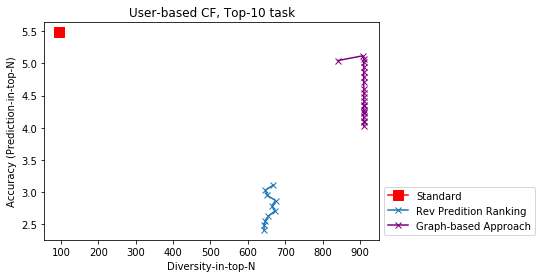

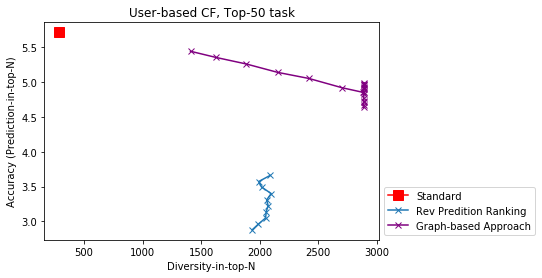

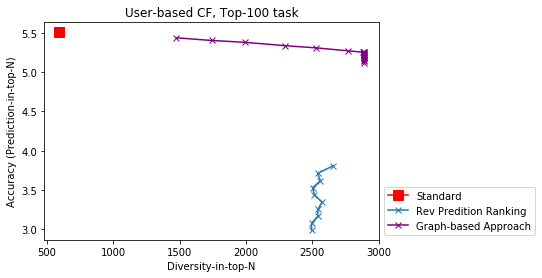

In [41]:
test_all(predicted_ratings_user_based_CF, N_list, 'User-based CF')

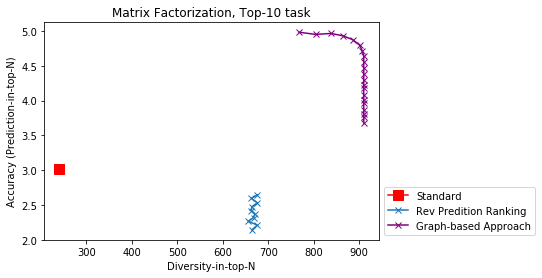

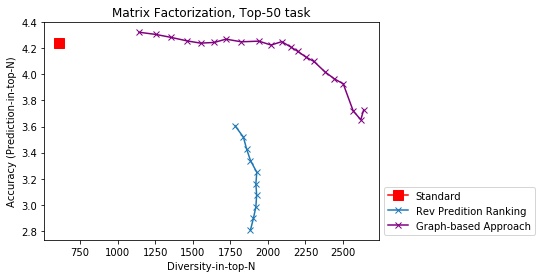

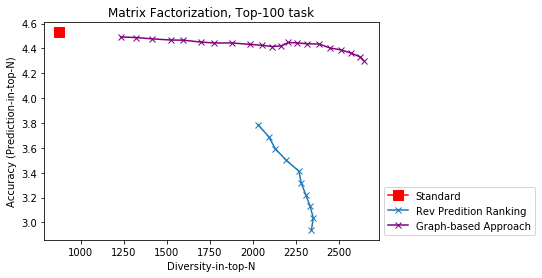

In [42]:
test_all(predicted_ratings_matrix_factorization_CF, N_list, 'Matrix Factorization')

From the evaluation, we can see that the proposed graph-based approach approach can greatly improve aggregate diversity at a very small sacrifice of accuracy.

# 6 Conclusion

In this project, we implemented a novel algorithm that transforms the problem of maxmizing aggregate diversity into a maximum flow problem. The evaluation proved it to be effective.